In [1]:
import pm4py
from collections import defaultdict
import numpy as np
import pandas as pd
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from collections import Counter
from graphviz import Digraph

In [2]:
log = xes_importer.apply('Road_Traffic_Fine_Management_Process.xes')

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

## 2-way filter algorithm for process discovery

Idea:
1. Find most common end-2-end traces, order them according to occurence. Most common trace is core trace. To add a trace, find the next most common end-2-end trace that has a new activity in there. Display the new activity when the activity-slider value is increased

2. To filter for trace: First find out the most common activities as described in step 1 then compute all product combination between these activities (edge occurence A -> B, B -> A, A -> A). On the lowest level show only the core trace edge combinations. When increasing the value add the most common edge combination for the given activities. 



In [3]:
def get_all_traces_and_occurences(log):
    """
    Returns a list with tuples that contains end-2-end traces and their occurences in the log
    """
    traces = [tuple(event['concept:name'] for event in trace) for trace in log]
    trace_counts = Counter(traces)
    return trace_counts.most_common()

def get_all_edges_and_occurences(log):
    """
    Returns a Counter Object that contains all edges from the dfg and their occurence

    Return: {(A, B): number_of_occurence,...}
    """
    return pm4py.algo.discovery.dfg.algorithm.apply(log)

Core Trace: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection') (Frequency: 56482)
Send for Credit Collection


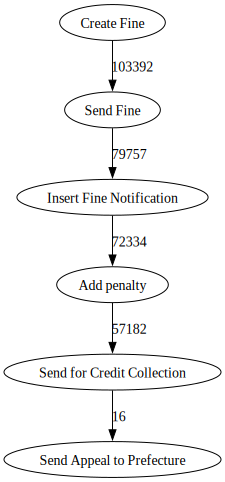

In [6]:
traces = [tuple(event['concept:name'] for event in trace) for trace in log]
trace_counts = Counter(traces)
core_trace, core_count = trace_counts.most_common(1)[0]
print(f"Core Trace: {core_trace} (Frequency: {core_count})")


dfg, start_activities, end_activities = pm4py.discover_dfg(log)

def get_core_dfg(core_trace):
    core_dfg = {}
    for i in range(len(core_trace) - 1):
        edge = (core_trace[i], core_trace[i+1])
        core_dfg[edge] = dfg.get(edge, 0)
    return core_dfg

def render_dfg(dfg):
    dot = Digraph(format='svg')
    activities = set([edge[0] for edge in dfg.keys()]).union(set([edge[1] for edge in dfg.keys()]))
    for activity in activities:
        dot.node(activity)
    for (from_act, to_act), freq in dfg.items():
        dot.edge(from_act, to_act, label=str(freq))
    return dot

render_dfg(get_core_dfg(core_trace))

def extend_dfg(core_dfg, dfg, num_activities):
    extended_dfg = core_dfg.copy()
    current_last_activity = core_trace[-1]
    print(current_last_activity)
    
    for _ in range(num_activities):
        next_activities = {k: v for k, v in dfg.items() if k[0] == current_last_activity and k not in extended_dfg}
        if not next_activities:
            break
        next_activity = max(next_activities, key=next_activities.get)[1]
        edge = (current_last_activity, next_activity)
        extended_dfg[edge] = dfg[edge]
        current_last_activity = next_activity
    
    return extended_dfg

render_dfg(extend_dfg(get_core_dfg(core_trace), dfg, 1))

In [7]:
def find_additional_entries(tuple1, tuple2):
    """Finds the entries that are in tuple1 but not in tuple2.

    Args:
        tuple1: The first tuple.
        tuple2: The second tuple.

    Returns:
        A list of entries that are in tuple1 but not in tuple2.
    """

    additional_entries = []
    for item in tuple1:
        if item not in tuple2:
            additional_entries.append(item)
    return additional_entries

In [28]:
# find core trace
all_traces = get_all_traces_and_occurences(log)
core_trace = all_traces[0]

# render core trace
core_variant = pm4py.filtering.filter_variants(log, core_trace)
dfg, start, end = pm4py.discover_dfg(core_variant)
# render_dfg(dfg)

current_trace = core_trace
current_trace = list(current_trace[0])
# print(current_trace)


# determine number of total activites to not search through all traces

index = 0
additional_activities_index_list = {}

for trace in all_traces:
    additional_activities = find_additional_entries(trace[0], current_trace)
    if additional_activities:
        # print(f"trace with new activity: {trace}")
        # print(f"current activity: {current_trace}")
        # print(f"additional activity {additional_activities}")
        additional_activities_index_list[tuple(additional_activities)] = index

        # append activity to current_trace
        current_trace.extend(additional_activities)
        # print(current_trace)
    index += 1

# print(additional_activities_index_list)

# this loop adds all cases together that are between the last one and the new one
# for k, v in additional_activities_index_list.items():
#     print(v, k)
#     # render core trace
#     all_variants = []
#     for trace in all_traces[:v+1]:
#         all_variants.append(trace[0])
#     print(all_variants)
#     trace = pm4py.filtering.filter_variants(log, all_variants)
#     dfg, start, end = pm4py.discover_dfg(trace)
#     pm4py.save_vis_dfg(dfg, start, end, str(k)+ ".svg")

# this loop adds only the cases together that add a new activity
print(additional_activities_index_list.values())
list_index_new_activity_added = list(additional_activities_index_list.values())
for i in range(1, len(list_index_new_activity_added)+1):
    all_indexes = list_index_new_activity_added[:i]
    print(all_indexes)
    all_variants = []
    for index in all_indexes:
        all_variants.append(all_traces[index][0])
    print(all_variants)
    trace = pm4py.filtering.filter_variants(log, all_variants)
    dfg, start, end = pm4py.discover_dfg(trace)
    pm4py.save_vis_dfg(dfg, start, end, str(i)+ ".svg")


# ToDo: It works that only one activitiy is added. However, all the extra edges that are not necessary to build the central edges
# are added anyway. So we need to filter them out based on the next slider value.

# compute all edge combinations for given amount of activities

dict_values([1, 7, 12, 13])
[1]
[('Create Fine', 'Payment')]
[1, 7]
[('Create Fine', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture')]
[1, 7, 12]
[('Create Fine', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture', 'Receive Result Appeal from Prefecture', 'Notify Result Appeal to Offender', 'Payment')]
[1, 7, 12, 13]
[('Create Fine', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture', 'Receive Result Appeal from Prefecture', '

In [9]:
print(all_traces[:1][0][0])

print(all_variants)


('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection')
[('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection'), ('Create Fine', 'Payment'), ('Create Fine', 'Send Fine'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Payment'), ('Create Fine', 'Send Fine', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Send for Credit Collection'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Send for Credit Collection'), ('Create Fine', 'Send Fine', 'Insert Fine Notification'

In [8]:
# different methods to get the variants of the process log

# pm4py.stats.get_variants(log)

# pm4py.stats.get_variants_as_tuples(log)

# for variant, subdf in pm4py.split_by_process_variant(log):
#     print(variant)
#     print(subdf)

In [9]:
# Filter methods of pm4py that dont do the thing I want

# filtered_log = pm4py.filtering.filter_variants(log, [('Create Fine', 'Payment')])
# dfg, start, end = pm4py.discover_dfg(filtered_log)
# render_dfg(dfg)

# filtered_between = pm4py.filter_between(log, 'Payment', 'Send for Credit Collection')
# dfg, start, end = pm4py.discover_dfg(filtered_between)
# render_dfg(dfg)

# # Show complete traces that contains the edge. NOT WHAT WE WANT
# filtered_relations = pm4py.filtering.filter_directly_follows_relation(log, [('Payment', 'Send for Credit Collection')])
# dfg, start, end = pm4py.discover_dfg(filtered_relations)
# render_dfg(dfg)

# Filter trace segments where you can specify if they have prior or proceeding activities
# filtered_trace_segments = pm4py.filtering.filter_trace_segments(log, admitted_traces=[['...', 'Payment', 'Send for Credit Collection']])
# dfg, start, end = pm4py.discover_dfg(filtered_trace_segments)
# render_dfg(dfg)
